In [2]:
import tensorflow as tf
import numpy as np
from models.MC_3D_model import get_mc_model
tf.random.set_seed(42)

In [3]:
# uncomment to download dataset
#!wget https://zenodo.org/record/5208230/files/nodulemnist3d.npz

## Loading Example Dataset (NoduleMNIST)
dataset source:  https://medmnist.com/

In [4]:
data = np.load("nodulemnist3d.npz")
X_train, y_train, X_val, y_val, X_test, y_test = data.values()

In [5]:
X_train, X_val, X_test = X_train[..., None]/255, X_val[..., None]/255, X_test[..., None]/255
X_train.shape, y_train.shape

((1158, 28, 28, 28, 1), (1158, 1))

## Instantiating 3D Deep Learning Model

In [6]:
model = get_mc_model(input_shape=X_train.shape[1:],
                     dropout=0.1,
                     is_mnist=True)
acc = tf.keras.metrics.BinaryAccuracy()
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[acc])

## Training Deep Learning Model

In [7]:
model.fit(X_train, y_train,
          batch_size=64,
          validation_data=(X_val, y_val),
          epochs=5)

Epoch 1/5
19/19 [==============================] - 62s 3s/step - loss: 0.7554 - binary_accuracy: 0.6615 - val_loss: 0.6248 - val_binary_accuracy: 0.7515
Epoch 2/5
19/19 [==============================] - 45s 2s/step - loss: 0.6196 - binary_accuracy: 0.7297 - val_loss: 0.6708 - val_binary_accuracy: 0.7091
Epoch 3/5
19/19 [==============================] - 45s 2s/step - loss: 0.6282 - binary_accuracy: 0.7297 - val_loss: 0.6048 - val_binary_accuracy: 0.7394
Epoch 4/5
19/19 [==============================] - 45s 2s/step - loss: 0.5988 - binary_accuracy: 0.7358 - val_loss: 0.5824 - val_binary_accuracy: 0.7394
Epoch 5/5
19/19 [==============================] - 45s 2s/step - loss: 0.6077 - binary_accuracy: 0.7323 - val_loss: 0.5943 - val_binary_accuracy: 0.7273


## Evaluating Model performance on test set

In [8]:
from models.model_utils import monte_carlo_predict
y_pred = monte_carlo_predict(model, X_test, num_samples=15, batch_size=32)
print("test-set accuracy", float(acc(y_test, np.mean(y_pred, axis=0))))

100%|██████████| 15/15 [02:12<00:00,  8.80s/it]


test-set accuracy 0.8422576189041138


## Model Interpretability Analysis

In [9]:
import matplotlib.pyplot as plt
from interpretability_tools.occlusion_sensitivity import OcclusionSensitivity
from interpretability_tools.smoothgrad import SmoothGrad

In [10]:
sm = SmoothGrad()
oc = OcclusionSensitivity()
i = 1
img = X_test[i:i+1]
label = int(y_test[i])

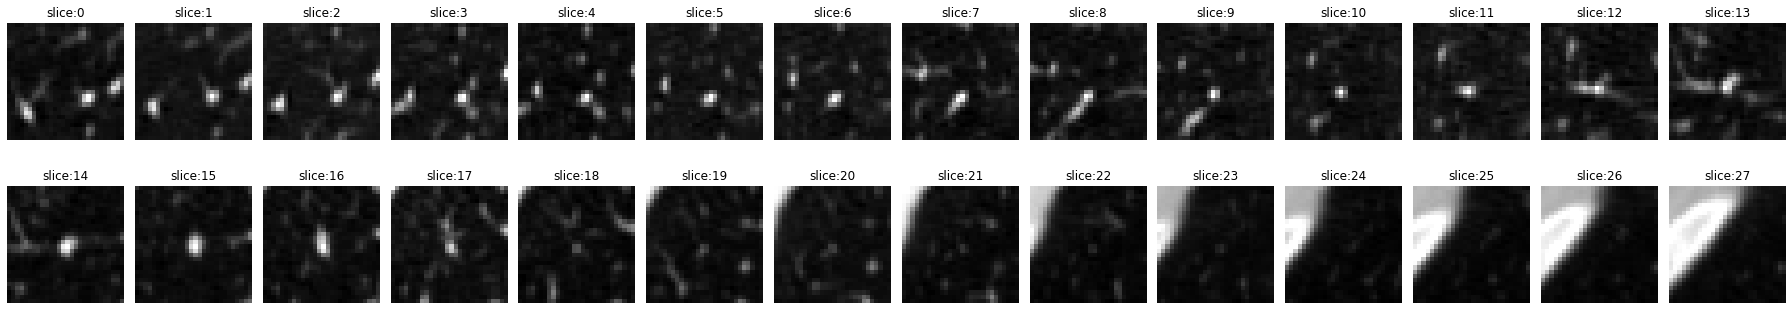

In [11]:
fig, axes = plt.subplots(ncols=14,nrows=2, figsize=(25, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(img[..., i, 0].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"slice:{i}")
plt.tight_layout()
plt.show()

### SmoothGrad

In [73]:
_, gradximg = sm.explain(img,
                    model,
                    class_index=label,
                    num_samples=5,
                    noise=1.0)

100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


returning channel unspecific interpretability map


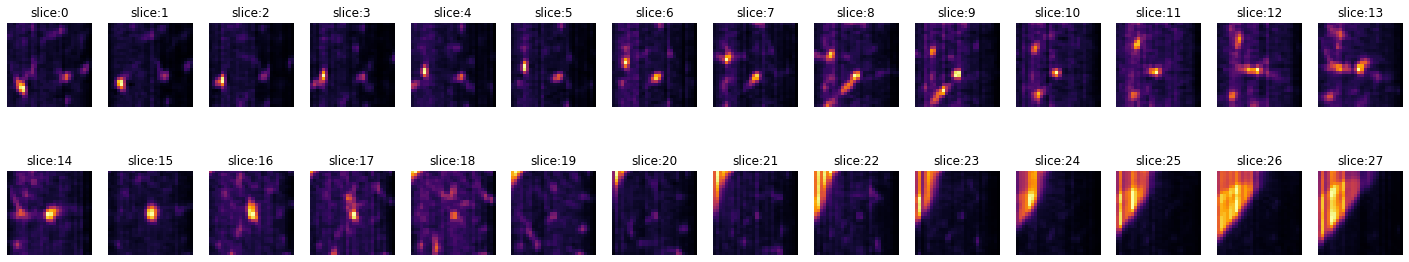

In [74]:
fig, axes = plt.subplots(ncols=14, nrows=2, figsize=(25, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(gradximg[..., i, 0].squeeze(), cmap='inferno')
    ax.axis('off')
    ax.set_title(f"slice:{i}")
plt.show()

### Occlusion Sensivity

In [66]:
occ_map = oc.explain(img, model, class_index=label, patch_size=7)

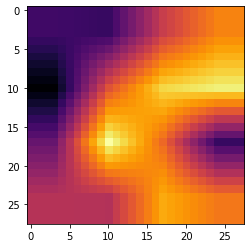

In [64]:
plt.imshow(occ_map, cmap='inferno')
plt.show()